In [1]:
import numpy as np
import pandas as pd
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import matplotlib.pyplot as plt

from sys import path as pylib #im naming it as pylib so that we won't get confused between os.path and sys.path 
import os
pylib += [os.path.abspath(r'/home/Jay/Notebooks/Group9_emotion_detection/torchMoji')]

In [2]:
data = pd.read_csv('../../deepmoji/data/train.txt', sep = '\t')

In [3]:
label2emotion = {0: "others", 1: "happy", 2: "sad", 3: "angry"}
emotion2label = {"others": 0, "happy": 1, "sad": 2, "angry": 3}

emoticons_additional = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_additional]
)


def tokenize(text):
    text = " ".join(text_processor.pre_process_doc(text))
    return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


### Load raw data

In [5]:
x=[]
y=[]

for ind, row in data.iterrows():
    y.append(emotion2label[row['label']])
    x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [6]:
test_data = pd.read_csv('../../deepmoji/data/test.txt', sep = '\t')
test_x = []
test_y=[]

for ind, row in test_data.iterrows():
    test_y.append(emotion2label[row['label']])
    test_x.append(tokenize(row['turn1'])+' <eos> '+tokenize(row['turn2']) + ' <eos> '+tokenize(row['turn3']))

In [7]:
from __future__ import print_function, division, unicode_literals
import json

from torchmoji.sentence_tokenizer import SentenceTokenizer
from torchmoji.model_def import torchmoji_feature_encoding
from torchmoji.model_def import torchmoji_emojis
from torchmoji.global_variables import PRETRAINED_PATH, VOCAB_PATH

def encode_deepmoji(x):
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    model = torchmoji_feature_encoding(PRETRAINED_PATH)
    print(model)
    print('Encoding texts..')
    encoding = np.zeros((len(x), 2304))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

def encode_emoji(x):
    model = torchmoji_emojis(PRETRAINED_PATH)
    maxlen = 30
    batch_size = 32

    print('Tokenizing using dictionary from {}'.format(VOCAB_PATH))
    with open(VOCAB_PATH, 'r') as f:
        vocabulary = json.load(f)
    st = SentenceTokenizer(vocabulary, maxlen)
    tokenized, _, _ = st.tokenize_sentences(x)
    print('Loading model from {}.'.format(PRETRAINED_PATH))
    print(model)
    print('Running predictions.')
    
    encoding = np.zeros((len(x), 64))
    for i in range(0, len(x), 300):    
        encoding[i:i+300] = model(tokenized[i:i+300])
    return encoding

### Create vectors

In [10]:
x_vec = encode_deepmoji(x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [11]:
test_x_vec = encode_deepmoji(test_x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
Loading weights for embed.weight
Loading weights for lstm_0.weight_ih_l0
Loading weights for lstm_0.weight_hh_l0
Loading weights for lstm_0.bias_ih_l0
Loading weights for lstm_0.bias_hh_l0
Loading weights for lstm_0.weight_ih_l0_reverse
Loading weights for lstm_0.weight_hh_l0_reverse
Loading weights for lstm_0.bias_ih_l0_reverse
Loading weights for lstm_0.bias_hh_l0_reverse
Loading weights for lstm_1.weight_ih_l0
Loading weights for lstm_1.weight_hh_l0
Loading weights for lstm_1.bias_ih_l0
Loading weights for lstm_1.bias_hh_l0
Loading weights for lstm_1.weight_ih_l0_reverse
Loading weights for lstm_1.weight_hh_l0_reverse
Loading weights for lstm_1.bias_ih_l0_reverse
Loading weights for lstm_1.bias_hh_l0_reverse
Loading weights for attention_layer.attention_vector
Ignoring weights 

In [20]:
np.save('../../dm_emb/deepmoji_train_x.npy', x_vec)

In [21]:
np.save('../../dm_emb/deepmoji_test_x.npy', test_x_vec)

### Load saved vectors

In [8]:
x_vec = np.load('../../dm_emb/deepmoji_train_x.npy')
test_x_vec = np.load('../../dm_emb/deepmoji_test_x.npy')

In [9]:
print(x_vec.shape)
print(test_x_vec.shape)

(30160, 2304)
(5509, 2304)


In [ ]:
emoji_all = encode_emoji(x)
emoji_test = encode_emoji(test_x)

Tokenizing using dictionary from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/vocabulary.json
Loading model from /home/Jay/Notebooks/Group9_emotion_detection/torchMoji/model/pytorch_model.bin.
TorchMoji(
  (embed): Embedding(50000, 256)
  (embed_dropout): Dropout2d(p=0)
  (lstm_0): LSTMHardSigmoid(256, 512, batch_first=True, bidirectional=True)
  (lstm_1): LSTMHardSigmoid(1024, 512, batch_first=True, bidirectional=True)
  (attention_layer): Attention(2304, return attention=False)
  (final_dropout): Dropout(p=0)
  (output_layer): Sequential(
    (0): Linear(in_features=2304, out_features=64, bias=True)
    (1): Softmax()
  )
)
Running predictions.


/home/Jay/dev32/lib/python3.5/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
tokens = [v for k,v in label2emotion.items()]
tokens

In [ ]:
y=np.array(y)
idx_others=np.where(y==0)[0]

In [ ]:
idx = np.r_[np.random.choice(idx_others,6000),np.where(y==1)[0],np.where(y==2)[0],np.where(y==3)[0]]

In [ ]:
idx.shape

In [ ]:
deepmoji_train = x_vec[idx]
y_train = y[idx]
emoji_train = emoji_all[idx]

In [ ]:
deepmoji_test = test_x_vec

### Models

In [ ]:
from sklearn import metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import itertools
from sklearn.linear_model import LogisticRegression

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def print_metrics(mc_prediction):
    print(metrics.classification_report(test_y, mc_prediction, target_names=tokens))
    print("Accuracy:", metrics.accuracy_score(test_y, mc_prediction))
    print("Precision:", metrics.precision_score(test_y, mc_prediction, average='macro'))
    print("Recall:", metrics.recall_score(test_y, mc_prediction, average='macro'))
    print("F1 score: ", metrics.f1_score(test_y, mc_prediction, average='macro'))
    #print("Confusion Matrix: \n", metrics.confusion_matrix(mc_Y_test, mc_prediction))
    plot_confusion_matrix(metrics.confusion_matrix(test_y, mc_prediction), tokens)

### Logistic Regression

In [ ]:
LR = Pipeline([('scaler', MinMaxScaler()), ('clf', LogisticRegression(random_state=0))])
#LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 

In [ ]:
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.96      0.78      0.86      4677
      happy       0.01      0.03      0.02       284
        sad       0.03      0.05      0.04       298
      angry       0.02      0.04      0.03       250

avg / total       0.82      0.67      0.74      5509

Accuracy: 0.6667271737157379
Precision: 0.25685062762658706
Recall: 0.22592733444691956
F1 score:  0.2361575249532991
Confusion matrix, without normalization
[[3638  368  286  385]
 [  67    8   15  194]
 [  27  245   16   10]
 [  41   21  177   11]]


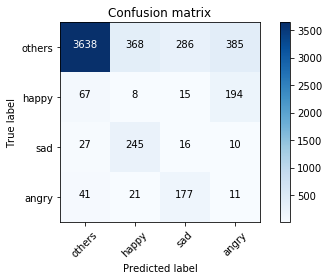

In [37]:
LR = LogisticRegression(random_state=0)
LR.fit(deepmoji_train, y_train) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.95      0.89      0.92      4677
      happy       0.02      0.03      0.02       284
        sad       0.04      0.04      0.04       298
      angry       0.02      0.03      0.03       250

avg / total       0.81      0.76      0.79      5509

Accuracy: 0.7643855509166818
Precision: 0.2583687682877274
Recall: 0.2503158536494909
F1 score:  0.2536601967461106
Confusion matrix, without normalization
[[4181  197  130  169]
 [ 117    9   10  148]
 [  49  233   13    3]
 [  64   18  160    8]]


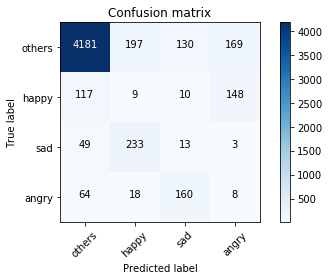

In [38]:
LR = LogisticRegression(random_state=0).fit(x_vec, y) 
print_metrics(LR.predict(deepmoji_test))

             precision    recall  f1-score   support

     others       0.91      0.71      0.80      4677
      happy       0.02      0.05      0.03       284
        sad       0.04      0.08      0.06       298
      angry       0.01      0.03      0.02       250

avg / total       0.78      0.61      0.68      5509

Accuracy: 0.6099110546378653
Precision: 0.24672374620882095
Recall: 0.21504279122493736
F1 score:  0.22412877698673406
Confusion matrix, without normalization
[[3317  513  352  495]
 [ 157   13    8  106]
 [  73  198   23    4]
 [  85   29  129    7]]


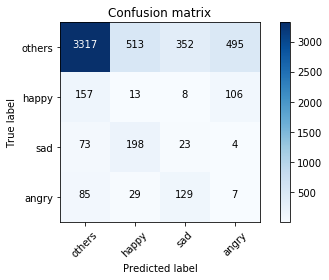

In [42]:
LR = LogisticRegression(random_state=0).fit(emoji_train, y_train) 
print_metrics(LR.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.89      0.94      0.91      4677
      happy       0.01      0.01      0.01       284
        sad       0.06      0.04      0.05       298
      angry       0.00      0.00      0.00       250

avg / total       0.76      0.80      0.78      5509

Accuracy: 0.79960065347613
Precision: 0.2395185231833492
Recall: 0.2489792303174525
F1 score:  0.24381931163902254
Confusion matrix, without normalization
[[4388  149  117   23]
 [ 269    4    1   10]
 [ 146  139   13    0]
 [ 143   13   94    0]]


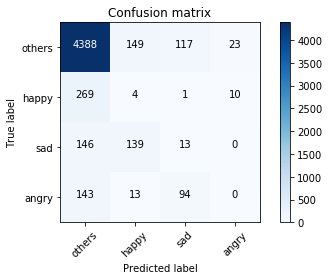

In [46]:
LR = LogisticRegression(random_state=0).fit(emoji_all, y) 
print_metrics(LR.predict(emoji_test))

### Naive Bayes

             precision    recall  f1-score   support

     others       0.93      0.76      0.84      4677
      happy       0.02      0.05      0.03       284
        sad       0.02      0.03      0.02       298
      angry       0.01      0.03      0.02       250

avg / total       0.79      0.65      0.71      5509

Accuracy: 0.6509348339081503
Precision: 0.246332078257513
Recall: 0.2169947452890309
F1 score:  0.2267601093806323
Confusion matrix, without normalization
[[3556  544  204  373]
 [ 112   15    8  149]
 [  72  216    8    2]
 [  80   29  134    7]]


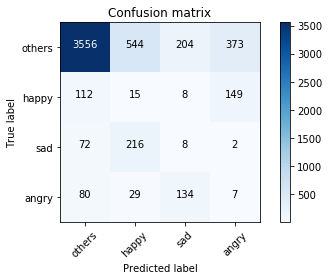

In [39]:
mc_nb = Pipeline([('scaler', MinMaxScaler()), ('clf', MultinomialNB())])
mc_nb.fit(deepmoji_train, y_train)
print_metrics(mc_nb.predict(deepmoji_test))

/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     others       0.88      0.90      0.89      4677
      happy       0.02      0.03      0.02       284
        sad       0.05      0.04      0.04       298
      angry       0.00      0.00      0.00       250

avg / total       0.75      0.77      0.76      5509

Accuracy: 0.7716463968052278
Precision: 0.23778139993774927
Recall: 0.24248382608886865
F1 score:  0.23926906597548683
Confusion matrix, without normalization
[[4232  342  103    0]
 [ 272    8    4    0]
 [ 152  135   11    0]
 [ 146   18   86    0]]


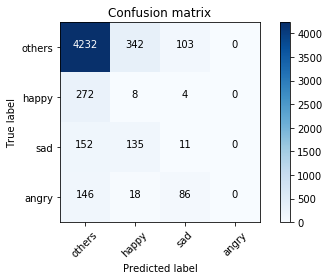

In [48]:
mc_nb = Pipeline([('clf', MultinomialNB())])
mc_nb.fit(emoji_train, y_train)
print_metrics(mc_nb.predict(emoji_test))

/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/Jay/dev32/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

     others       0.85      1.00      0.92      4677
      happy       0.00      0.00      0.00       284
        sad       0.00      0.00      0.00       298
      angry       0.00      0.00      0.00       250

avg / total       0.72      0.85      0.78      5509

Accuracy: 0.8489744055182429
Precision: 0.21224360137956072
Recall: 0.25
F1 score:  0.22957981543294717
Confusion matrix, without normalization
[[4677    0    0    0]
 [ 284    0    0    0]
 [ 298    0    0    0]
 [ 250    0    0    0]]


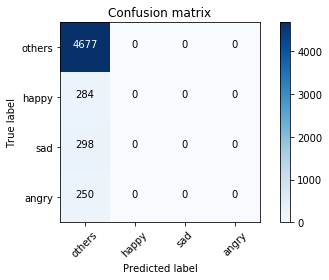

In [49]:
mc_nb.fit(emoji_all, y)
print_metrics(mc_nb.predict(emoji_test))

### SVM - One vs One

             precision    recall  f1-score   support

     others       0.93      0.70      0.80      4677
      happy       0.02      0.04      0.02       284
        sad       0.04      0.07      0.05       298
      angry       0.01      0.04      0.02       250

avg / total       0.79      0.61      0.68      5509

Accuracy: 0.6050099836630968
Precision: 0.24895058291821245
Recall: 0.21148257568421897
F1 score:  0.22270801686873545
Confusion matrix, without normalization
[[3293  438  329  617]
 [ 127   11    6  140]
 [  61  212   20    5]
 [  64   20  157    9]]


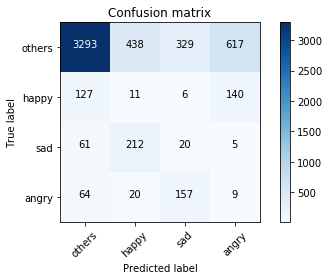

In [43]:
mc_svm_ovo = svm.SVC(decision_function_shape='ovo', kernel='linear', C=100)

mc_svm_ovo.fit(emoji_train, y_train)
print_metrics(mc_svm_ovo.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.91      0.90      0.91      4677
      happy       0.02      0.02      0.02       284
        sad       0.04      0.04      0.04       298
      angry       0.02      0.01      0.01       250

avg / total       0.78      0.77      0.77      5509

Accuracy: 0.7703757487747322
Precision: 0.24647754813492959
Recall: 0.24490793989116333
F1 score:  0.24539183082273563
Confusion matrix, without normalization
[[4222  212  143  100]
 [ 206    7    2   69]
 [ 108  176   12    2]
 [ 111   14  122    3]]


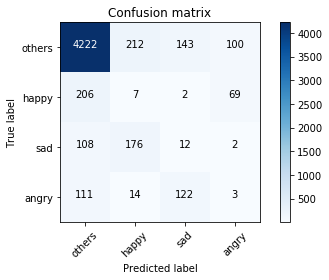

In [50]:
mc_svm_ovo.fit(emoji_all, y)
print_metrics(mc_svm_ovo.predict(emoji_test))

### SVM One vs Rest

             precision    recall  f1-score   support

     others       0.93      0.70      0.80      4677
      happy       0.02      0.04      0.02       284
        sad       0.04      0.07      0.05       298
      angry       0.01      0.04      0.02       250

avg / total       0.79      0.61      0.68      5509

Accuracy: 0.6050099836630968
Precision: 0.24895058291821245
Recall: 0.21148257568421897
F1 score:  0.22270801686873545
Confusion matrix, without normalization
[[3293  438  329  617]
 [ 127   11    6  140]
 [  61  212   20    5]
 [  64   20  157    9]]


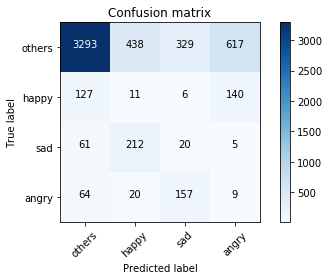

In [44]:
mc_svm_ovr = svm.SVC(decision_function_shape='ovr', kernel='linear', C=100)
mc_svm_ovr.fit(emoji_train, y_train)
print_metrics(mc_svm_ovr.predict(emoji_test))

             precision    recall  f1-score   support

     others       0.91      0.90      0.91      4677
      happy       0.02      0.02      0.02       284
        sad       0.04      0.04      0.04       298
      angry       0.02      0.01      0.01       250

avg / total       0.78      0.77      0.77      5509

Accuracy: 0.7703757487747322
Precision: 0.24647754813492959
Recall: 0.24490793989116333
F1 score:  0.24539183082273563
Confusion matrix, without normalization
[[4222  212  143  100]
 [ 206    7    2   69]
 [ 108  176   12    2]
 [ 111   14  122    3]]


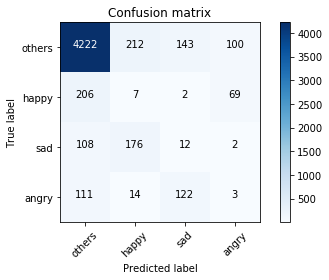

In [51]:
mc_svm_ovr.fit(emoji_all, y)
print_metrics(mc_svm_ovr.predict(emoji_test))